#**Tecnológico de Monterrey**

# **Proyecto Integrador**
## Avance 2
## Ingeniería de características
###Dra. Grettel Barceló Alonso
###EQUIPO 21
###Bernardo Mijango Flores - A01793654
###Dalia Isabel López Tapia - A01245026
###David Valles Canedo - A01191310
12 de mayo de 2024

### Importaciones, Funciones, Dependencias y Pasos Iniciales

In [12]:
# conectamos al drive de google para la lectura de los archivos csv
#from google.colab import drive
#drive.mount('/content/drive')

Mounted at /content/drive


In [3]:

!pip install feature_engine


Defaulting to user installation because normal site-packages is not writeable


In [5]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns   # para un mejor despliegue de los gráficos

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from feature_engine.imputation import CategoricalImputer
from feature_engine.outliers import OutlierTrimmer


In [42]:
# función para mostrar un diagrama de caja encima de un histograma
def plot_boxplot_hist(data, variable):
  f,(ax_box, ax_hist) = plt.subplots(2,
                                     sharex=True,
                                     gridspec_kw={"height_ratios":(0.50,0.85)})
  sns.boxplot(x=data[variable],ax=ax_box)
  sns.histplot(data=data, x=variable, ax=ax_hist)
  ax_box.set(xlabel="")
  plt.title(variable)
  plt.show()


In [43]:
# función para encontrar los límites de una distribución variable usando la regla de proximidad del rango intercuartil:

def find_limits(df,variable,fold):
  IQR = df[variable].quantile(0.75)-df[variable].quantile(0.25)
  lower_limit = df[variable].quantile(0.25)-(IQR * fold)
  upper_limit = df[variable].quantile(0.75)+(IQR * fold)
  return lower_limit, upper_limit

Se realizo una corrección en la consulta de la base de datos para obtener la edad del cliente al momento del desembolso del crédito, en el avance 1 nos dimos cuenta de este error, además se agregaron los castigos en el mismo archivo dando un total de 4,382,214 registros resultado de los 4,254,537 del archivo de pagos mas 127,677 del archivo de castigos

In [8]:
# Lectura de los archivos csv
#file_path = '/content/drive/MyDrive/DataSetProyecto/GrupalTodoCorregido.csv'

# Lectura del archivo
file_path = 'DataSet/GrupalTodoCorregido.csv'

label = ["IdCliente","FechaAltaCliente","CodigoGrupo","EdadCliente","Genero","EstadoCivil","Escolaridad","CapacidadPago","Localidad","CodigoSucursal","CodigoASesor","NumeroCredito","CicloCliente","FechaDesembolso","FechaVencimiento","FechaCancelacion","Plazo","PeriodoPago","EstatusCredito","MontoCredito","CuotaNumero","CuotaFechaVencimiento","CuotaFechaCancelacion","MontoCuota","MontoCapital","SaldoCapital","EstatusCuota","DiasAtraso"]

# Obtenemos el dataframe
grupal_df = pd.read_csv(file_path, names=label)

grupal_df.shape

(4382214, 28)

In [9]:
grupal_df.isnull().sum()

IdCliente                   0
FechaAltaCliente            0
CodigoGrupo                 0
EdadCliente                 0
Genero                      0
EstadoCivil                 0
Escolaridad              1243
CapacidadPago               0
Localidad                   0
CodigoSucursal              0
CodigoASesor                0
NumeroCredito               0
CicloCliente                0
FechaDesembolso             0
FechaVencimiento            0
FechaCancelacion            0
Plazo                       0
PeriodoPago                 0
EstatusCredito              0
MontoCredito                0
CuotaNumero                 0
CuotaFechaVencimiento       0
CuotaFechaCancelacion     128
MontoCuota                  0
MontoCapital                0
SaldoCapital                0
EstatusCuota                0
DiasAtraso                128
dtype: int64

Text(0.5, 1.0, 'Proporcion de datos faltantes por variable')

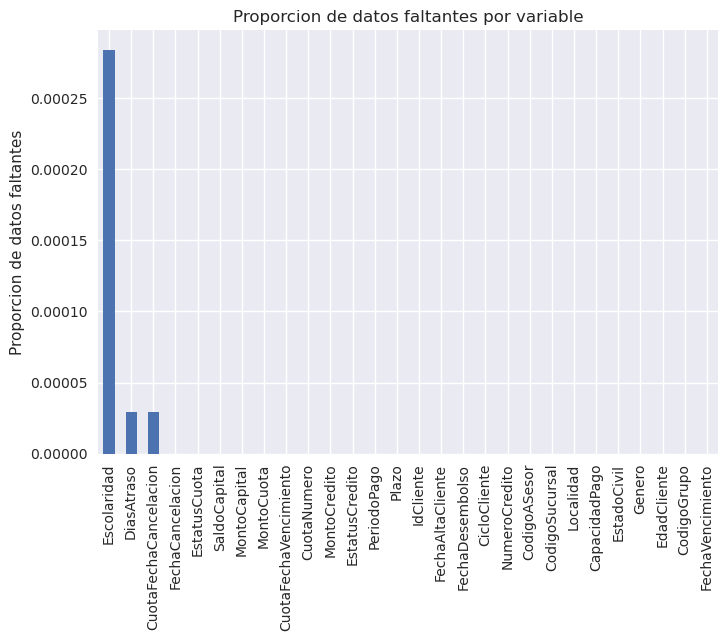

In [10]:
# visualizamos la proporcion de los datos faltantes

with plt.style.context("seaborn"):
  grupal_df.isnull().mean().sort_values(ascending=False).plot.bar(rot=90)

plt.ylabel("Proporcion de datos faltantes")
plt.title("Proporcion de datos faltantes por variable")


Al ser un procentaje menor al 0.028 % se decide eliminarlos de la muestra

In [11]:
# eliminamos los valores nulos
gpdf = grupal_df.dropna()

In [12]:
gpdf.isnull().values.any()

False

In [13]:
gpdf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4380844 entries, 0 to 4382213
Data columns (total 28 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   IdCliente              int64  
 1   FechaAltaCliente       object 
 2   CodigoGrupo            int64  
 3   EdadCliente            int64  
 4   Genero                 object 
 5   EstadoCivil            int64  
 6   Escolaridad            object 
 7   CapacidadPago          float64
 8   Localidad              int64  
 9   CodigoSucursal         int64  
 10  CodigoASesor           object 
 11  NumeroCredito          int64  
 12  CicloCliente           int64  
 13  FechaDesembolso        object 
 14  FechaVencimiento       object 
 15  FechaCancelacion       object 
 16  Plazo                  int64  
 17  PeriodoPago            object 
 18  EstatusCredito         object 
 19  MontoCredito           float64
 20  CuotaNumero            int64  
 21  CuotaFechaVencimiento  object 
 22  CuotaFechaCancelacion  

In [13]:
gpdf.shape

(4380844, 28)

In [16]:
print(gpdf.describe(exclude=[object]))

          IdCliente   CodigoGrupo   EdadCliente   EstadoCivil  CapacidadPago  \
count  4.380844e+06  4.380844e+06  4.380844e+06  4.380844e+06   4.380844e+06   
mean   5.902005e+04  8.415457e+02  3.944503e+01  3.268472e+00   7.633413e+03   
std    3.836093e+04  5.770191e+02  1.305678e+01  1.669057e+00   3.069242e+04   
min    4.000000e+00  0.000000e+00  1.500000e+01  1.000000e+00  -6.391200e+06   
25%    2.367200e+04  3.130000e+02  2.900000e+01  2.000000e+00   2.400000e+03   
50%    5.530600e+04  8.230000e+02  3.800000e+01  3.000000e+00   6.000000e+03   
75%    9.229100e+04  1.244000e+03  4.800000e+01  5.000000e+00   1.017600e+04   
max    1.376940e+05  2.594000e+03  1.010000e+02  7.000000e+00   8.000400e+06   

          Localidad  CodigoSucursal  NumeroCredito  CicloCliente  \
count  4.380844e+06    4.380844e+06   4.380844e+06  4.380844e+06   
mean   7.607020e+03    6.142390e+00   6.143053e+09  5.265920e+00   
std    3.124029e+03    4.096959e+00   4.096748e+09  4.991101e+00   
min    

In [14]:
# Reemplazamos los valores negativos de la variable DiasAtraso por 0 ya que son pagos anticipados
gpdf.loc[gpdf['DiasAtraso'] < 1,'DiasAtraso'] = 0


In [15]:
print(gpdf.describe(include=[object]))

               FechaAltaCliente   Genero Escolaridad CodigoASesor  \
count                   4380844  4380844     4380844      4380844   
unique                    15962        2          14          528   
top     2004-02-05 00:00:00.000        F          1A       ACORZO   
freq                       7669  4378507     1302653        98613   

                FechaDesembolso         FechaVencimiento  \
count                   4380844                  4380844   
unique                     3268                     2816   
top     2013-04-30 00:00:00.000  2019-06-04 00:00:00.000   
freq                       6944                     4869   

               FechaCancelacion   PeriodoPago EstatusCredito  \
count                   4380844       4380844        4380844   
unique                     3303             3              2   
top     2015-12-08 00:00:00.000  CATORCENA(S)            CAN   
freq                       7115       3816897        4253254   

          CuotaFechaVencimiento 

In [16]:
print(gpdf.describe(exclude=[object]))

          IdCliente   CodigoGrupo   EdadCliente   EstadoCivil  CapacidadPago  \
count  4.380844e+06  4.380844e+06  4.380844e+06  4.380844e+06   4.380844e+06   
mean   5.902005e+04  8.415457e+02  3.944503e+01  3.268472e+00   7.633413e+03   
std    3.836093e+04  5.770191e+02  1.305678e+01  1.669057e+00   3.069242e+04   
min    4.000000e+00  0.000000e+00  1.500000e+01  1.000000e+00  -6.391200e+06   
25%    2.367200e+04  3.130000e+02  2.900000e+01  2.000000e+00   2.400000e+03   
50%    5.530600e+04  8.230000e+02  3.800000e+01  3.000000e+00   6.000000e+03   
75%    9.229100e+04  1.244000e+03  4.800000e+01  5.000000e+00   1.017600e+04   
max    1.376940e+05  2.594000e+03  1.010000e+02  7.000000e+00   8.000400e+06   

          Localidad  CodigoSucursal  NumeroCredito  CicloCliente  \
count  4.380844e+06    4.380844e+06   4.380844e+06  4.380844e+06   
mean   7.607020e+03    6.142390e+00   6.143053e+09  5.265920e+00   
std    3.124029e+03    4.096959e+00   4.096748e+09  4.991101e+00   
min    

In [17]:
gpdf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4380844 entries, 0 to 4382213
Data columns (total 28 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   IdCliente              int64  
 1   FechaAltaCliente       object 
 2   CodigoGrupo            int64  
 3   EdadCliente            int64  
 4   Genero                 object 
 5   EstadoCivil            int64  
 6   Escolaridad            object 
 7   CapacidadPago          float64
 8   Localidad              int64  
 9   CodigoSucursal         int64  
 10  CodigoASesor           object 
 11  NumeroCredito          int64  
 12  CicloCliente           int64  
 13  FechaDesembolso        object 
 14  FechaVencimiento       object 
 15  FechaCancelacion       object 
 16  Plazo                  int64  
 17  PeriodoPago            object 
 18  EstatusCredito         object 
 19  MontoCredito           float64
 20  CuotaNumero            int64  
 21  CuotaFechaVencimiento  object 
 22  CuotaFechaCancelacion  

### Se agregan los valores Maximos, la Media y la Mediana de la variable DiasAtraso por cliente y por credito

In [18]:
# obtenemos el Maximo Dias de Atraso y las siguientes variables numericas
gpmdadf = gpdf.groupby(['IdCliente','EdadCliente','NumeroCredito','CicloCliente','Plazo','EstadoCivil','EstatusCredito','Escolaridad'])['DiasAtraso'].max().reset_index()

# renombramos la columna de la media
gpmdadf.rename(columns={'DiasAtraso':'DAMax'}, inplace=True)

gpmdadf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 380284 entries, 0 to 380283
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   IdCliente       380284 non-null  int64  
 1   EdadCliente     380284 non-null  int64  
 2   NumeroCredito   380284 non-null  int64  
 3   CicloCliente    380284 non-null  int64  
 4   Plazo           380284 non-null  int64  
 5   EstadoCivil     380284 non-null  int64  
 6   EstatusCredito  380284 non-null  object 
 7   Escolaridad     380284 non-null  object 
 8   DAMax           380284 non-null  float64
dtypes: float64(1), int64(6), object(2)
memory usage: 26.1+ MB


In [19]:
# obtenemos media de los Dias de Atraso por credito
gpmeandf = gpdf.groupby(['IdCliente','NumeroCredito'])['DiasAtraso'].mean().reset_index()

# obtenemos mediana de los Dias de Atraso por credito
gpmediandf = gpdf.groupby(['IdCliente','NumeroCredito'])['DiasAtraso'].median().reset_index()

# renombramos la columna de la media
gpmeandf.rename(columns={'DiasAtraso':'DAMean'}, inplace=True)

# renombramos la columna de la mediana
gpmediandf.rename(columns={'DiasAtraso':'DAMedian'}, inplace=True)


In [20]:
gpmeandf.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 380284 entries, 0 to 380283
Data columns (total 3 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   IdCliente      380284 non-null  int64  
 1   NumeroCredito  380284 non-null  int64  
 2   DAMean         380284 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 8.7 MB


In [21]:
gpmediandf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 380284 entries, 0 to 380283
Data columns (total 3 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   IdCliente      380284 non-null  int64  
 1   NumeroCredito  380284 non-null  int64  
 2   DAMedian       380284 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 8.7 MB


In [22]:
print(gpmdadf[gpmdadf['IdCliente']==6])

   IdCliente  EdadCliente  NumeroCredito  CicloCliente  Plazo  EstadoCivil  \
1          6           34     1000539201             1     15            5   
2          6           34     1000619301             2     15            5   
3          6           35     1000696601             3     15            5   
4          6           36     1000835501             4     25            5   

  EstatusCredito Escolaridad  DAMax  
1            CAN          8A    0.0  
2            CAN          8A    2.0  
3            CAN          8A    2.0  
4            CAN          8A  185.0  


In [23]:
print(gpmeandf[gpmeandf['IdCliente']==6])

   IdCliente  NumeroCredito     DAMean
1          6     1000539201   0.000000
2          6     1000619301   0.333333
3          6     1000696601   0.466667
4          6     1000835501  23.400000


In [24]:
print(gpmediandf[gpmediandf['IdCliente']==6])

   IdCliente  NumeroCredito  DAMedian
1          6     1000539201       0.0
2          6     1000619301       0.0
3          6     1000696601       0.0
4          6     1000835501       1.0


In [25]:
# agregamos la columan de la media
newdf = pd.merge(gpmdadf, gpmeandf[['IdCliente','NumeroCredito','DAMean']], on=['IdCliente','NumeroCredito'], how='left')

# agregamos la columna de la mediana
newdf = pd.merge(newdf, gpmediandf[['IdCliente','NumeroCredito','DAMedian']], on=['IdCliente','NumeroCredito'], how='left')

In [26]:
# mostramos los datos del cliente 6
print(newdf[newdf['IdCliente']==6])

   IdCliente  EdadCliente  NumeroCredito  CicloCliente  Plazo  EstadoCivil  \
1          6           34     1000539201             1     15            5   
2          6           34     1000619301             2     15            5   
3          6           35     1000696601             3     15            5   
4          6           36     1000835501             4     25            5   

  EstatusCredito Escolaridad  DAMax     DAMean  DAMedian  
1            CAN          8A    0.0   0.000000       0.0  
2            CAN          8A    2.0   0.333333       0.0  
3            CAN          8A    2.0   0.466667       0.0  
4            CAN          8A  185.0  23.400000       1.0  


In [27]:
newdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 380284 entries, 0 to 380283
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   IdCliente       380284 non-null  int64  
 1   EdadCliente     380284 non-null  int64  
 2   NumeroCredito   380284 non-null  int64  
 3   CicloCliente    380284 non-null  int64  
 4   Plazo           380284 non-null  int64  
 5   EstadoCivil     380284 non-null  int64  
 6   EstatusCredito  380284 non-null  object 
 7   Escolaridad     380284 non-null  object 
 8   DAMax           380284 non-null  float64
 9   DAMean          380284 non-null  float64
 10  DAMedian        380284 non-null  float64
dtypes: float64(3), int64(6), object(2)
memory usage: 31.9+ MB


In [29]:
newdf.describe()

,IdCliente,EdadCliente,NumeroCredito,CicloCliente,Plazo,EstadoCivil,DAMax,DAMean,DAMedian
count,380284.000000,380284.000000,3.802840e+05,380284.000000,380284.000000,380284.000000,380284.000000,380284.000000,380284.000000
mean,62850.419447,39.294380,6.294027e+09,5.248467,11.520361,3.275194,10.777138,3.690072,2.633708
std,38647.293146,13.031957,4.132016e+09,5.021308,2.592052,1.677993,37.695548,13.788344,12.977543
min,4.000000,15.000000,7.000000e+02,1.000000,3.000000,1.000000,0.000000,0.000000,0.000000
25%,27767.750000,29.000000,3.000682e+09,2.000000,10.000000,2.000000,1.000000,0.083333,0.000000
50%,60289.500000,38.000000,6.000743e+09,3.000000,12.000000,3.000000,1.000000,0.416667,0.000000
75%,96880.250000,48.000000,9.000381e+09,7.000000,12.000000,5.000000,5.000000,1.166667,1.000000
max,137694.000000,101.000000,2.100005e+10,43.000000,36.000000,7.000000,1977.000000,489.500000,585.500000


In [34]:
Inpagodf = newdf[newdf['DAMax']>0]

In [36]:
Inpagodf.describe()

,IdCliente,EdadCliente,NumeroCredito,CicloCliente,Plazo,EstadoCivil,DAMax,DAMean,DAMedian
count,294647.000000,294647.000000,2.946470e+05,294647.000000,294647.000000,294647.000000,294647.000000,294647.000000,294647.000000
mean,63057.879717,39.383303,6.564762e+09,5.106446,11.614478,3.234345,13.909434,4.762564,3.399176
std,38097.250011,13.067681,4.025942e+09,4.969038,2.574487,1.679900,42.312848,15.500558,14.654824
min,4.000000,16.000000,7.000000e+02,1.000000,3.000000,1.000000,1.000000,0.033333,0.000000
25%,29049.500000,29.000000,3.000980e+09,2.000000,10.000000,2.000000,1.000000,0.250000,0.000000
50%,60467.000000,38.000000,6.001185e+09,3.000000,12.000000,2.000000,2.000000,0.750000,0.500000
75%,96282.500000,48.000000,9.000512e+09,7.000000,12.000000,5.000000,7.000000,1.625000,1.000000
max,137328.000000,101.000000,2.100004e+10,43.000000,36.000000,7.000000,1977.000000,489.500000,585.500000


In [47]:
Inpagodf = newdf[newdf['EstatusCredito']=='CAI']

In [48]:
Inpagodf.describe()

,IdCliente,EdadCliente,NumeroCredito,CicloCliente,Plazo,EstadoCivil,DAMax,DAMean,DAMedian
count,12316.000000,12316.000000,1.231600e+04,12316.000000,12316.000000,12316.000000,12316.000000,12316.000000,12316.000000
mean,90240.011286,38.936099,7.616462e+09,4.521192,10.366759,3.198928,159.405245,64.673680,49.474911
std,34512.369694,13.061890,4.418646e+09,4.609893,2.272152,1.764784,53.627023,29.034053,46.655119
min,71.000000,16.000000,1.000399e+09,1.000000,5.000000,1.000000,0.000000,0.000000,0.000000
25%,76297.750000,28.000000,5.000501e+09,1.000000,8.000000,2.000000,125.000000,46.733333,10.000000
50%,99735.500000,37.000000,7.001035e+09,3.000000,10.000000,2.000000,156.000000,60.208333,36.500000
75%,115696.250000,48.000000,1.000058e+10,6.000000,12.000000,5.000000,189.000000,77.500000,77.000000
max,135962.000000,87.000000,2.100002e+10,34.000000,30.000000,7.000000,1685.000000,396.875000,479.000000


In [49]:
Inpagodf.head()

,IdCliente,EdadCliente,NumeroCredito,CicloCliente,Plazo,EstadoCivil,EstatusCredito,Escolaridad,DAMax,DAMean,DAMedian
111,71,79,18000021701,15,15,3,CAI,7B,152.0,19.333333,0.0
137,73,41,18000021706,16,15,2,CAI,8A,152.0,19.333333,0.0
144,74,74,18000036003,7,12,6,CAI,7B,307.0,197.833333,230.0
185,77,61,18000035803,17,15,3,CAI,7B,322.0,189.466667,196.0
239,82,40,18000021703,15,15,6,CAI,8A,152.0,19.333333,0.0


In [39]:
Inpagodf = newdf[newdf['DAMax']>180]
Inpagodf.describe()

,IdCliente,EdadCliente,NumeroCredito,CicloCliente,Plazo,EstadoCivil,DAMax,DAMean,DAMedian
count,6314.000000,6314.000000,6.314000e+03,6314.000000,6314.000000,6314.000000,6314.000000,6314.000000,6314.000000
mean,74927.775261,38.377257,6.582271e+09,3.533576,10.972125,3.077922,223.419227,78.629834,54.781913
std,33017.144230,12.896113,3.419212e+09,3.570506,2.578810,1.724290,108.342451,39.046190,61.150123
min,6.000000,18.000000,1.000341e+09,1.000000,5.000000,1.000000,181.000000,12.333333,0.000000
25%,47515.750000,28.000000,3.001315e+09,1.000000,8.000000,2.000000,186.000000,52.583333,8.000000
50%,88948.500000,37.000000,7.000644e+09,2.000000,12.000000,2.000000,196.000000,72.416667,21.500000
75%,100600.750000,47.000000,9.000671e+09,4.000000,12.000000,5.000000,209.000000,99.062500,107.000000
max,132489.000000,83.000000,1.900007e+10,27.000000,25.000000,7.000000,1977.000000,489.500000,585.500000


### buscar la cuota del maximo dias de atraso, dividirlo entre el plazo para el porcentaje de vida del credito

In [58]:
# obtenemos el Maximo Dias de Atraso y las siguientes variables numericas
mda = gpdf.groupby(['IdCliente','NumeroCredito'])['DiasAtraso'].max().reset_index()

mda.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 380284 entries, 0 to 380283
Data columns (total 3 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   IdCliente      380284 non-null  int64  
 1   NumeroCredito  380284 non-null  int64  
 2   DiasAtraso     380284 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 8.7 MB


In [75]:
cuotas = pd.merge(mda, gpdf, how='inner', on=['IdCliente','NumeroCredito','DiasAtraso'])

print(cuotas[cuotas['IdCliente']==6])

    IdCliente  NumeroCredito  DiasAtraso         FechaAltaCliente  \
1           6     1000539201         0.0  2004-01-19 00:00:00.000   
2           6     1000539201         0.0  2004-01-19 00:00:00.000   
3           6     1000539201         0.0  2004-01-19 00:00:00.000   
4           6     1000539201         0.0  2004-01-19 00:00:00.000   
5           6     1000539201         0.0  2004-01-19 00:00:00.000   
6           6     1000539201         0.0  2004-01-19 00:00:00.000   
7           6     1000539201         0.0  2004-01-19 00:00:00.000   
8           6     1000539201         0.0  2004-01-19 00:00:00.000   
9           6     1000539201         0.0  2004-01-19 00:00:00.000   
10          6     1000539201         0.0  2004-01-19 00:00:00.000   
11          6     1000539201         0.0  2004-01-19 00:00:00.000   
12          6     1000539201         0.0  2004-01-19 00:00:00.000   
13          6     1000539201         0.0  2004-01-19 00:00:00.000   
14          6     1000539201      

### buscar la clusterizacion de estos datos

### Eliminando valores atípicos

In [28]:
# obtenemos las siguientes variables numericas
dfnum = pd.DataFrame(gpdf[['EdadCliente','CicloCliente','Plazo','DAMax','DAMean','DAMedian']])

dfnum.info()

KeyError: "['DAMax', 'DAMean', 'DAMedian'] not in index"

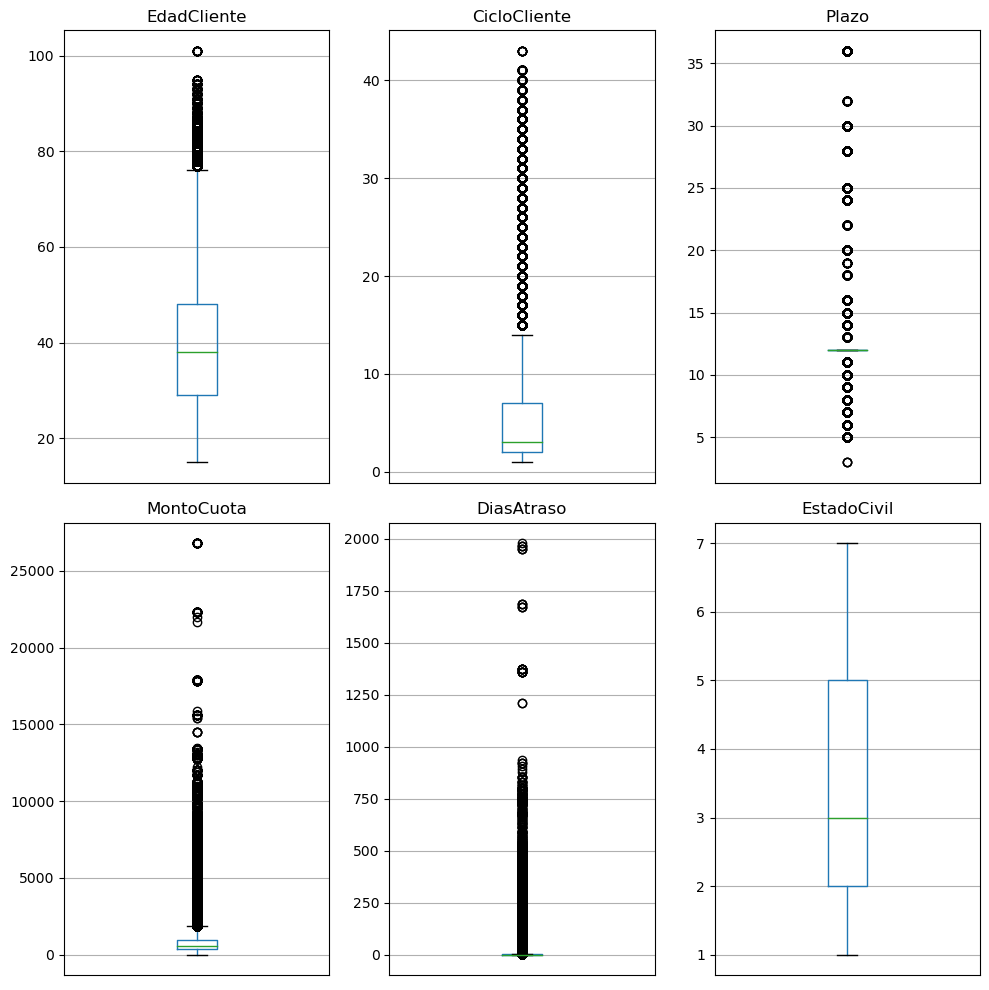

In [24]:
# graficamos para revisar valores atipicos de las primeras 6 variables numericas
fig, axes = plt.subplots(2, 3, figsize=(10, 10))  # Definimos una ventana de 3x3 nichos para incluir en cada uno de ellos un gráfico.

# Iterar sobre las columnas y generar un gráfico de caja para cada una
for k, ax in zip(range(0, 6), axes.flatten()):  # Usamos zip para iterar sobre los ejes y los índices
    dfnum.boxplot(column=dfnum.columns[k], ax=ax)  # Generar el gráfico de caja para la columna actual
    ax.set_title(dfnum.columns[k])  # Establecer el título del gráfico
    ax.set_xticks([])  # Eliminar las etiquetas del eje x para mayor claridad

plt.tight_layout()  # Ajustar el diseño para evitar superposiciones
plt.show()

In [25]:
# Determinamos los limintes de la variable EdadCliente

lower_limit, upper_limit = find_limits(dfnum,"EdadCliente",3)

In [26]:
# Conservemos las observaciones cuyo valor sea mayor o igual a (ge) el límite inferior:
inliner = dfnum["EdadCliente"].ge(lower_limit)
dfnum = dfnum.loc[inliner]

In [27]:
# Retenemos las observaciones cuyo valor sea menor o igual a (le) el límite superior:
inliner = dfnum["EdadCliente"].le(upper_limit)

dfnum = dfnum.loc[inliner]

In [28]:
trimmer = OutlierTrimmer(variables=["EdadCliente","CicloCliente","DiasAtraso"],
                         capping_method="iqr",
                         tail="both",
                         fold=1.5,)

In [29]:
trimmer.fit(dfnum)

OutlierTrimmer(capping_method='iqr', fold=1.5, tail='both',
               variables=['EdadCliente', 'CicloCliente', 'DiasAtraso'])

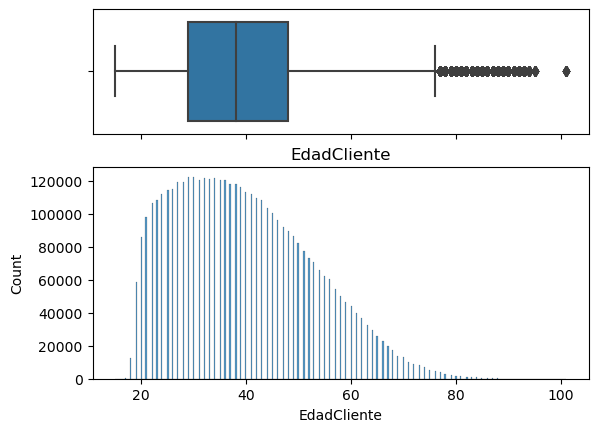

In [30]:
# Se muestra la distribucion de la variable EdadCliente
plot_boxplot_hist(dfnum,"EdadCliente")

In [31]:
dftransf = trimmer.transform(dfnum)

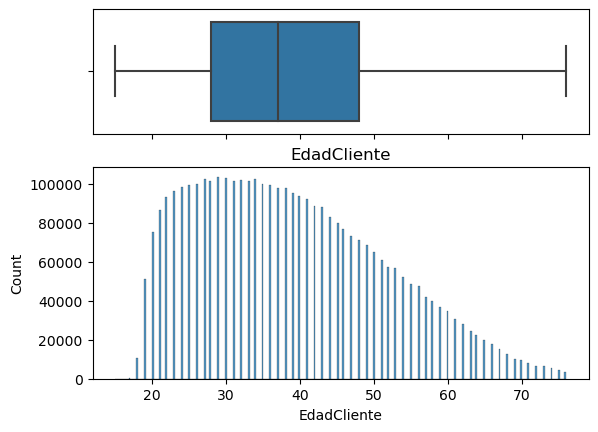

In [32]:
# Se muestra la distribucion de la variable EdadCliente
plot_boxplot_hist(dftransf,"EdadCliente")

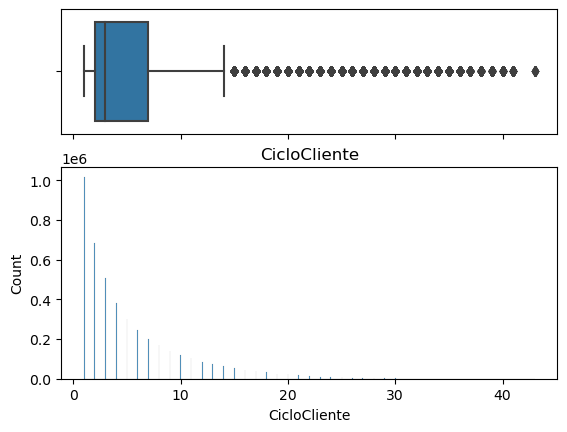

In [33]:
# Se muestra la distribucion de la variable CicloCliente
plot_boxplot_hist(dfnum,"CicloCliente")

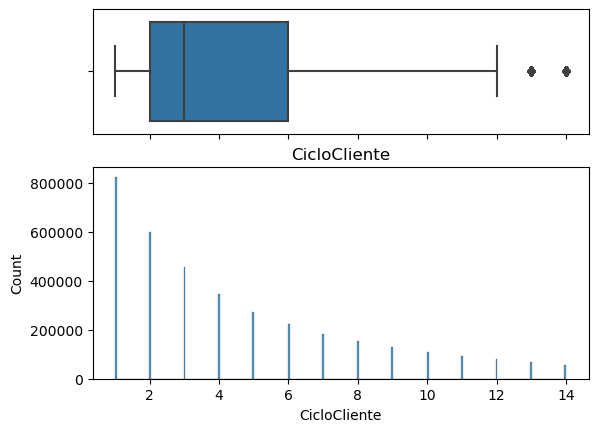

In [34]:
# Se muestra la distribucion de la variable EdadCliente
plot_boxplot_hist(dftransf,"CicloCliente")

In [35]:
newgpdf = dftransf.copy()
newgpdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3606092 entries, 0 to 4382213
Data columns (total 10 columns):
 #   Column          Dtype  
---  ------          -----  
 0   EdadCliente     int64  
 1   CicloCliente    int64  
 2   Plazo           int64  
 3   MontoCuota      float64
 4   DiasAtraso      float64
 5   EstadoCivil     int64  
 6   IdCliente       int64  
 7   NumeroCredito   int64  
 8   EstatusCredito  object 
 9   Escolaridad     object 
dtypes: float64(2), int64(6), object(2)
memory usage: 431.6+ MB


### Avance 2

Para la generación de nuevas características en este contexto de análisis de comportamiento de clientes de créditos grupales, se puede considerar varias estrategias para crear variables adicionales que capturen aspectos relevantes del comportamiento de pago de los clientes.


Este siguiente código creará una nueva columna llamada 'HistorialPagos' que contiene la cantidad total de pagos realizados por cada cliente. Esto dará una visión general del historial de pagos de cada cliente, lo que podría ser útil para el análisis de comportamiento de pago y la gestión de cobranza

In [36]:
# Agregamos una columna que nos indique los creditos pagados

# Convertimos las columnas de fechas a tipo datetime
#gpdf['FechaDesembolso'] = pd.to_datetime(gpdf['FechaDesembolso'])
#gpdf['FechaVencimiento'] = pd.to_datetime(gpdf['FechaVencimiento'])
#gpdf['FechaCancelacion'] = pd.to_datetime(gpdf['FechaCancelacion'])

# Filtramos los creditos que han sido pagados (asumiendo que 'PAGADO' es el estado de un credito pagado)
pagados = newgpdf[newgpdf['EstatusCredito'] == 'CAN']

# Calculamos el historial de créditos pagados contando el número de creditos pagados por cliente
historial_pagos =pagados.groupby("IdCliente").NumeroCredito.nunique().reset_index(name='HistorialPagos')

# Unimos el historial de pagos con el DataFrame original
newgpdf = pd.merge(newgpdf, historial_pagos, on=('IdCliente'), how='left')

# Mostramos el DataFrame con la nueva variable 'HistorialPagos'
print(newgpdf[['IdCliente', 'HistorialPagos']].head())

   IdCliente  HistorialPagos
0        261             2.0
1      30654             2.0
2        262             2.0
3        261             2.0
4      30654             2.0


In [37]:
newgpdf.fillna(0, inplace=True)

In [38]:
# Revisamos los diferentes codigos de categorias
print(newgpdf.Escolaridad.value_counts())

1A    1077711
2B     687468
7B     409614
4      402613
8A     396048
2A     260640
7A     174413
5       76671
8B      48762
1B      34356
1       29777
8C       4367
3        2558
6        1094
Name: Escolaridad, dtype: int64


In [39]:
# Creamos las variables binarias de escolaridad
dummies = pd.get_dummies(newgpdf['Escolaridad'], drop_first = True)
dummies.head()

,1A,1B,2A,2B,3,4,5,6,7A,7B,8A,8B,8C
0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,1,0,0,0,0
2,0,0,0,0,0,0,0,0,1,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,1,0,0,0,0


In [40]:
# Añadimos las variables binarias al DataFrame
newgpdf = pd.concat([newgpdf, dummies], axis = 1)

# Eliminamos la vairable original race
newgpdf = newgpdf.drop(columns=['Escolaridad'])

In [41]:
print(newgpdf.EstatusCredito.value_counts())

CAN    3570731
CAI      35361
Name: EstatusCredito, dtype: int64


In [42]:
# Creamos las variables binarias de EstatusCredito
dummies = pd.get_dummies(newgpdf['EstatusCredito'], drop_first = True)
dummies.head()

,CAN
0,1
1,1
2,1
3,1
4,1


In [43]:
# Añadimos las variables binarias al DataFrame
newgpdf = pd.concat([newgpdf, dummies], axis = 1)

# Eliminamos la vairable original race
newgpdf = newgpdf.drop(columns=['EstatusCredito'])

In [45]:
# Cambiamos el tipo de variable booleano a int
newgpdf["1A"] = newgpdf["1A"].astype(int)
newgpdf["1B"] = newgpdf["1B"].astype(int)
newgpdf["2A"] = newgpdf["2A"].astype(int)
newgpdf["2B"] = newgpdf["2B"].astype(int)
newgpdf["3"] = newgpdf["3"].astype(int)
newgpdf["4"] = newgpdf["4"].astype(int)
newgpdf["5"] = newgpdf["5"].astype(int)
newgpdf["6"] = newgpdf["6"].astype(int)
newgpdf["7A"] = newgpdf["7A"].astype(int)
newgpdf["7B"] = newgpdf["7B"].astype(int)
newgpdf["8A"] = newgpdf["8A"].astype(int)
newgpdf["8B"] = newgpdf["8B"].astype(int)
newgpdf["8C"] = newgpdf["8C"].astype(int)
newgpdf["CAN"] = newgpdf["CAN"].astype(int)


In [ ]:
# Seleccion de caracteristicas
#features = ['EdadCliente', 'Genero', 'CicloCliente','Plazo', 'MontoCredito', 'MontoCapital', 'SaldoCapital', 'MontoCuota','DiasAtraso','EstadoCivil','EstatusCredito', 'Escolaridad','HistorialPagos']


In [47]:
#newgpdf = gpdf[features]
newgpdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3606092 entries, 0 to 3606091
Data columns (total 23 columns):
 #   Column          Dtype  
---  ------          -----  
 0   EdadCliente     int64  
 1   CicloCliente    int64  
 2   Plazo           int64  
 3   MontoCuota      float64
 4   DiasAtraso      float64
 5   EstadoCivil     int64  
 6   IdCliente       int64  
 7   NumeroCredito   int64  
 8   HistorialPagos  float64
 9   1A              int32  
 10  1B              int32  
 11  2A              int32  
 12  2B              int32  
 13  3               int32  
 14  4               int32  
 15  5               int32  
 16  6               int32  
 17  7A              int32  
 18  7B              int32  
 19  8A              int32  
 20  8B              int32  
 21  8C              int32  
 22  CAN             int32  
dtypes: float64(3), int32(14), int64(6)
memory usage: 467.7 MB


In [48]:
# solo variables numerica
x_num = newgpdf.copy()

#### Preprocesamiento y creacion de pipeline

In [49]:
# fase de Escalamiento y normalizacion
num_pipeline = Pipeline([
    ('scaler', StandardScaler())
])


In [50]:
# fase de Codificacion de categorias
cat_pipeline = Pipeline([
    ('encoder', OneHotEncoder())
])

In [52]:
# pipeline con metodos de preprocesamiento
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_pipeline, num_variables)
    ])

NameError: name 'num_variables' is not defined

#### Correlación

In [53]:
# Calcular la matriz de correlación
correlation_matrix = x_num.corr()

# visualizar la matriz de correlación
print("Matriz de correlación en var numericas:")
print(correlation_matrix)

# características más correlacionadas con umbral del .5
threshold = 0.5
highly_correlated_features = set()
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            colname = correlation_matrix.columns[i]
            highly_correlated_features.add(colname)

print("\nCaracterísticas correlacionadas:")
print(highly_correlated_features)

Matriz de correlación en var numericas:
                EdadCliente  CicloCliente     Plazo  MontoCuota  DiasAtraso  \
EdadCliente        1.000000      0.179720  0.048250    0.078064    0.017433   
CicloCliente       0.179720      1.000000  0.001242    0.446171   -0.019318   
Plazo              0.048250      0.001242  1.000000    0.019048   -0.018736   
MontoCuota         0.078064      0.446171  0.019048    1.000000   -0.018627   
DiasAtraso         0.017433     -0.019318 -0.018736   -0.018627    1.000000   
EstadoCivil       -0.060520      0.034170 -0.002272    0.012116   -0.032988   
IdCliente         -0.168628     -0.184701 -0.456121   -0.052949    0.033780   
NumeroCredito      0.013970      0.018377 -0.229583   -0.002094    0.095325   
HistorialPagos     0.153953      0.653004  0.059899    0.305344   -0.056462   
1A                 0.031282      0.033223 -0.034688    0.017080   -0.009908   
1B                -0.008740     -0.001314 -0.029142   -0.002033    0.005247   
2A          

In [54]:
#Para identificar correlación
correlation_matrix = x_num.corr(numeric_only=True)

TypeError: corr() got an unexpected keyword argument 'numeric_only'

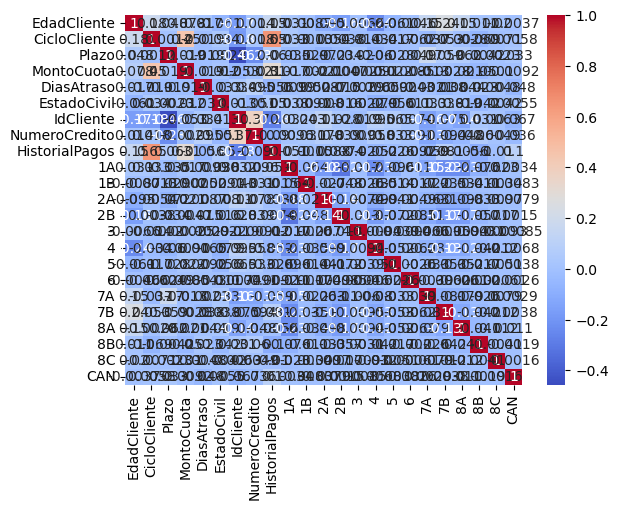

In [55]:

# Mapa de Correlacion
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

#### Umbral de Varianza

In [56]:

# Aplicar umbral de varianza con threshold de .1
threshold = 0.1
selector = VarianceThreshold(threshold=threshold)
X_selected = selector.fit_transform(x_num)

# Obtener los nombres de las características seleccionadas
selected_features = x_num.columns[selector.get_support()]

# Mostrar las características seleccionadas
print("Características seleccionadas con varianza superior al umbral:")
print(selected_features)

Características seleccionadas con varianza superior al umbral:
Index(['EdadCliente', 'CicloCliente', 'Plazo', 'MontoCuota', 'DiasAtraso',
       'EstadoCivil', 'IdCliente', 'NumeroCredito', 'HistorialPagos', '1A',
       '2B', '7B'],
      dtype='object')


#### PCA

In [57]:
pca_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('pca', PCA(n_components=2))
])


NameError: name 'preprocessor' is not defined

In [58]:
newgpdf.isnull().values.any()

False

In [59]:
principal_components = pca_pipeline.fit_transform(newgpdf)

NameError: name 'pca_pipeline' is not defined

In [60]:
principal_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

NameError: name 'principal_components' is not defined

In [61]:
# Exploración de la varianza
print("Varianza explicada por cada componente principal:")
print(pca_pipeline.named_steps['pca'].explained_variance_ratio_)



Varianza explicada por cada componente principal:


NameError: name 'pca_pipeline' is not defined

In [62]:
# plot
plt.figure(figsize=(10, 6))
plt.scatter(principal_df['PC1'], principal_df['PC2'], alpha=0.5)
plt.title('PCA de los Datos')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.grid(True)
plt.show()

NameError: name 'principal_df' is not defined

# Conclusiones

La idea detrás de establecer un umbral de varianza es eliminar aquellas características que tienen una baja variabilidad en sus valores, ya que estas características pueden no ser útiles para el modelo de aprendizaje automático y pueden incluso introducir ruido en el proceso de modelado. Es importante tener en cuenta que el umbral de varianza debe ajustarse de acuerdo con el problema específico y el conjunto de datos en cuestión. Un umbral muy bajo puede eliminar características útiles, mientras que un umbral muy alto puede no eliminar características irrelevantes. Por lo tanto, es común ajustar el umbral de varianza mediante prueba y error o utilizando métodos de validación cruzada para encontrar el valor óptimo que maximice el rendimiento del modelo.

Utilizamos el Análisis de Componentes Principales (PCA), es una técnica de reducción de dimensionalidad que se utiliza comúnmente en el análisis de datos y el aprendizaje automático. El objetivo es transformar un conjunto de variables correlacionadas en un nuevo conjunto de variables no correlacionadas llamadas componentes principales. Estos componentes principales son combinaciones lineales de las variables originales y están ordenados de manera que el primero capture la mayor varianza posible en los datos, el segundo capture la segunda mayor varianza, y así sucesivamente.

En el contexto de la gestión de cobranza con Inteligencia Artificial, la preparación de los datos debe centrarse en crear variables que capturen el comportamiento de pago de los clientes y en preparar los datos de manera que los modelos de aprendizaje automático puedan aprender patrones útiles para la clasificación de clientes según su riesgo de incumplimiento.